In [1]:
""" 
사용할 수 있는 Module

1. numpy
2. matplotlib
3. scipy


"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.constants as pc
from datetime import datetime
from IPython.display import Image

In [48]:
class N_Body_System():
    def __init__(self, n, n_mass=np.array([]), init_rx=np.array([]), init_ry=np.array([]), init_vx=np.array([]), init_vy=np.array([]), init_r_min=-100.0, init_r_max=100.0, init_v_max=0.1):
        """
        n: number of point masses
        init_rx: initial x positions of n point masses
        init_ry: initial y positions of n point masses
        init_vx: initial x velocities of n point masses
        init_vy: initial y velocities of n point masses

        """
        self.G = pc.physical_constants['Newtonian constant of gravitation'][0]
        self.time_unit = 0.001

        self.n = n
        self.n_mass = n_mass if n_mass.shape[0] != 0 else np.ones(n) * 10**15
        self.init_rx = init_rx if init_rx.shape[0] else np.random.default_rng().uniform(init_r_min, init_r_max, n)
        self.init_ry = init_ry if init_ry.shape[0] else np.random.default_rng().uniform(init_r_min, init_r_max, n)
        self.init_vx = init_vx if init_vx.shape[0] else np.random.default_rng().uniform(-init_v_max, init_v_max, n)
        self.init_vy = init_vy if init_vy.shape[0] else np.random.default_rng().uniform(-init_v_max, init_v_max, n)

        self.xrange = [max(self.init_rx), min(self.init_rx)]
        self.yrange = [max(self.init_ry), min(self.init_ry)]

        self.width = 5
        self.height = 5

        self.particles = [None for _ in range(self.n)]
        self.trajectories = [None for _ in range(self.n)]

        self.shortest_dist = 25

    def play(self, num_steps=2000):
        self.rx_history = np.array([self.init_rx])
        self.ry_history = np.array([self.init_ry])
        self.vx_history = np.array([self.init_vx])
        self.vy_history = np.array([self.init_vy])
        
        for t in range(num_steps):
            curr_rx = self.rx_history[-1]
            curr_ry = self.ry_history[-1]
            curr_vx = self.vx_history[-1]
            curr_vy = self.vy_history[-1]

            curr_ax = np.zeros(self.n)
            curr_ay = np.zeros(self.n)

            for i in range(self.n):
                for j in range(self.n):
                    if j == i:
                        continue
                    
                    dist = ((curr_rx[i] - curr_rx[j]) ** 2 + (curr_ry[i] - curr_ry[j]) ** 2) ** 0.5
                    if dist == 0:
                        continue
                    
                    dist = max(dist, self.shortest_dist)
                    
                    curr_ax[i] += -self.G * self.n_mass[j] * (curr_rx[i] - curr_rx[j]) / dist ** 3
                    curr_ay[i] += -self.G * self.n_mass[j] * (curr_ry[i] - curr_ry[j]) / dist ** 3
            
            next_vx = curr_vx + curr_ax * self.time_unit
            next_vy = curr_vy + curr_ay * self.time_unit

            next_rx = curr_rx + (curr_vx + next_vx) * self.time_unit / 2
            next_ry = curr_ry + (curr_vy + next_vy) * self.time_unit / 2

            self.xrange[0] = min(self.xrange[0], min(next_rx))
            self.xrange[1] = max(self.xrange[1], max(next_rx))
            self.yrange[0] = min(self.yrange[0], min(next_ry))
            self.yrange[1] = max(self.yrange[1], max(next_ry))
            
            self.rx_history = np.append(self.rx_history, next_rx.reshape(-1,self.n), axis=0)
            self.ry_history = np.append(self.ry_history, next_ry.reshape(-1,self.n), axis=0)
            self.vx_history = np.append(self.vx_history, next_vx.reshape(-1,self.n), axis=0)
            self.vy_history = np.append(self.vy_history, next_vy.reshape(-1,self.n), axis=0)
        
        ratio = ((self.yrange[1] - self.yrange[0]) / (self.xrange[1] - self.xrange[0])) ** 0.5
        self.width *= 1/ratio
        self.height *= ratio
        
    def plot(self):
        fig = plt.figure(figsize=(self.width, self.height))
        ax = fig.add_subplot(111)

        for i in range(self.n):
            ax.plot(self.rx_history[:,i], self.ry_history[:,i])
            ax.plot(self.rx_history[-1,i], self.ry_history[-1,i], 'o')
        
        plt.show()

    def init_animation(self):
        for i in range(self.n):
            self.particles[i].set_data([], [])
            self.trajectories[i].set_data([], [])
        return self.particles, self.trajectories

    def make_animation(self, i):
        for j in range(self.n):
            self.particles[j].set_data(self.rx_history[80*i,j], self.ry_history[80*i,j])
            self.trajectories[j].set_data(self.rx_history[:80*i,j], self.ry_history[:80*i,j])
        
        return self.particles, self.trajectories

    def animate(self):
        fig = plt.figure(figsize=(self.width, self.height))
        ax = plt.axes(xlim=tuple([self.xrange[0] - 0.1 * abs(self.xrange[0]), self.xrange[1] + 0.1 * abs(self.xrange[1])]), ylim=tuple([self.yrange[0] - 0.1 * abs(self.yrange[0]), self.yrange[1] + 0.1 * abs(self.yrange[1])]))

        for i in range(self.n):
            self.particles[i], = ax.plot([], [], 'o')

        for i in range(self.n):
            self.trajectories[i], = ax.plot([], [])

        anim = animation.FuncAnimation(fig, self.make_animation, init_func=self.init_animation, frames=self.rx_history.shape[0]//80, interval=1, blit=False);
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        anim.save(f'animations/n-body-problem_{current_date}.gif');
        
        with open(f'animations/n-body-problem_{current_date}.gif', 'rb') as file:
            display(Image(file.read()))

# Two-Body-Problem

18.267867965364758


MovieWriter ffmpeg unavailable; using Pillow instead.


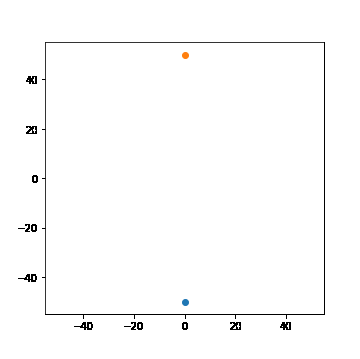

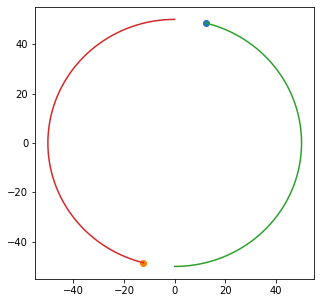

In [28]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([-R, R])

V = (n_body_system.G * n_body_system.n_mass[0] / (4 * R)) ** 0.5
n_body_system.init_vx = np.array([V, -V])
n_body_system.init_vy = np.array([0, 0])

print(V)

n_body_system.play(8000)

# n_body_system.plot()

n_body_system.animate()

MovieWriter ffmpeg unavailable; using Pillow instead.


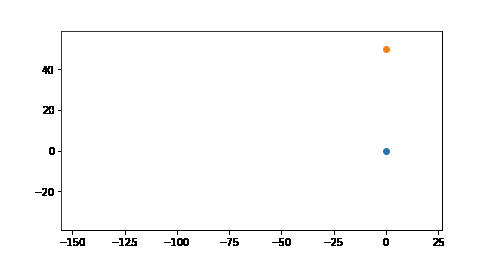

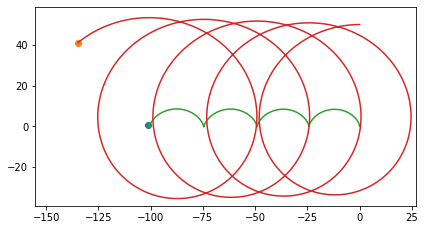

In [23]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 10

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

# n_body_system.plot()

n_body_system.animate()

MovieWriter ffmpeg unavailable; using Pillow instead.


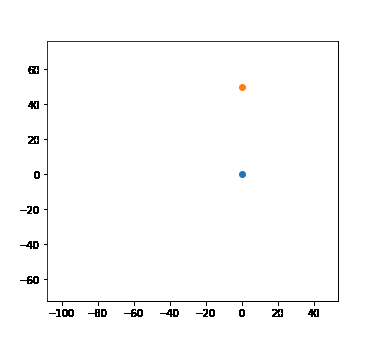

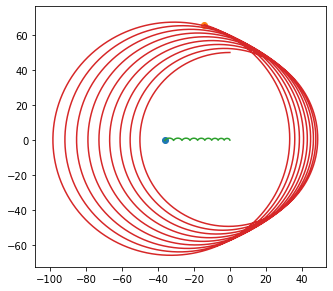

In [24]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 100

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

# n_body_system.plot()

n_body_system.animate()

MovieWriter ffmpeg unavailable; using Pillow instead.


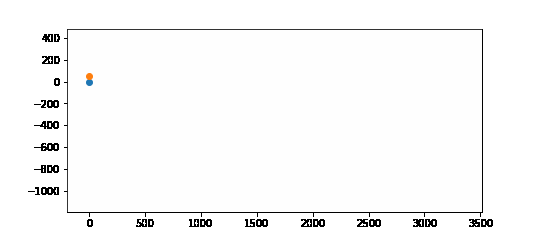

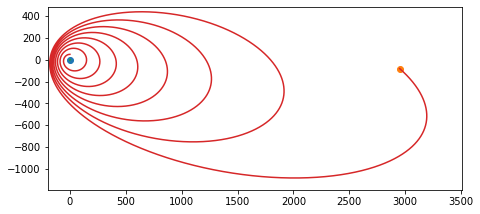

In [25]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([0, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 100000

V = (n_body_system.G * n_body_system.n_mass[0] / R) ** 0.5
n_body_system.init_vx = np.array([0, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(10000)

# n_body_system.plot()

n_body_system.animate()

MovieWriter ffmpeg unavailable; using Pillow instead.


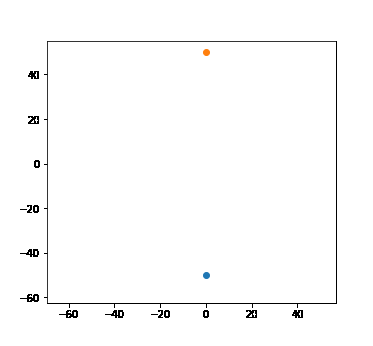

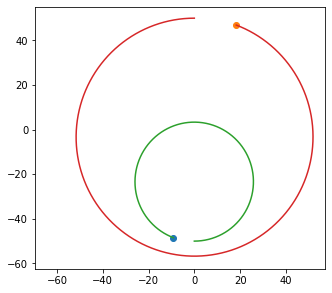

In [26]:
n_body_system = N_Body_System(2)

R = 50
n_body_system.init_rx = np.array([0, 0])
n_body_system.init_ry = np.array([-R, R])

n_body_system.n_mass[0] = n_body_system.n_mass[1] * 2

V = (n_body_system.G * n_body_system.n_mass[0] / R / 4) ** 0.5
n_body_system.init_vx = np.array([V/2, -V])
n_body_system.init_vy = np.array([0, 0])

n_body_system.play(9500)

# n_body_system.plot()

n_body_system.animate()

MovieWriter ffmpeg unavailable; using Pillow instead.


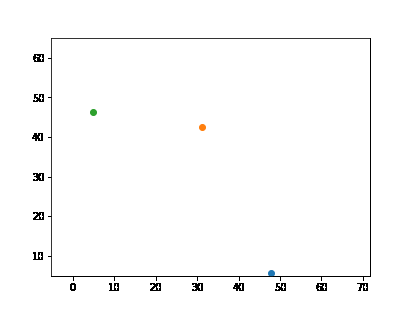

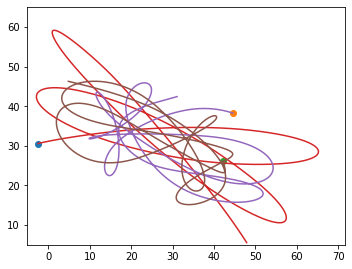

In [54]:
n_body_system = N_Body_System(3)

n_body_system.play(10000)

n_body_system.animate()

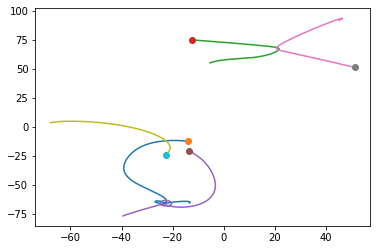

In [76]:
n_body_system = N_Body_System(5)

n_body_system.play()

n_body_system.plot()

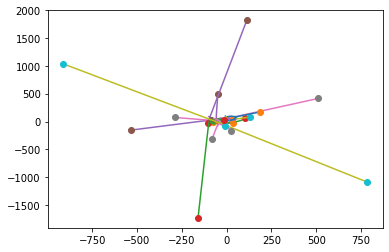

In [83]:
n_body_system = N_Body_System(20)

n_body_system.play()

n_body_system.plot()